# Tutorial for relaxation and vibration calculations using VASP and Phonopy.
## Introduction 

Welcome to this tutorial on the use of VASP and Phonopy to calculate phonon modes.

This first tutorial will guide you through a simple case of a $\mathsf{Si}$ crystal.<br>

The tutorial uses a Python interface to write and read inputs/output files from VASP, called Atomic Simulation Environment (ASE) (https://wiki.fysik.dtu.dk/ase/index.html).
While the inputs files are created using ASE and the following python scripts in this notebook, VASP is executed on the ILL  high-performance computing (HPC) cluster called `masterp`.
You will also learn how to submit jobs to this cluster.

If not already done, please copy this Jupyer file (.ipynb) to your home directory.

Let us start with importing all the necessary Python modules. We need both the numerical libraries, ASE and Phonopy packages.
Execute the following cell by selecting it and clicking the $ \blacktriangleright $ symbol in the toolbar.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from ase.visualize import view
from ase.calculators.vasp import Vasp
from ase.io import read, write
from phonopy import Phonopy, load
from phonopy.structure.atoms import PhonopyAtoms
from phonopy.interface.calculator import read_crystal_structure
from phonopy.interface.vasp import parse_set_of_forces, write_vasp
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
# %env VASP_PP_PATH=/nethome/ds/finel/MDANSE_School_Hands-on_VASP_Phonopy/
%env VASP_PP_PATH=.

env: VASP_PP_PATH=.


## Example 1: Si crystal

### 1. Preparing the structure

First, we will create a model of silicon crystal, display it and perform simple geometry optimization and phonon calculations using VASP and Phonopy.

ASE allows us to quickly generate structures - both molecular and periodic.

Here, we just tell ASE to create a silicon lattice for us.

In [3]:
si_conventional = bulk('Si', 'fcc', a=5.43, cubic=True)
si_primitive = bulk('Si', 'fcc', a=5.43)

We can visualize the cell using one of several tools which come with ASE

In [ ]:
view(si_conventional, viewer='x3d')

You can rotate the structure and zoom in and out using your mouse.

We can also see details of the generated structure. Let's check unit cell lengths in Angstrom.

In [4]:
si_conventional.get_cell()

Cell([5.43, 5.43, 5.43])

Fractional atomic positions within the cell can be queried with `get_positions()` method. We have 4 Si atoms per conventional cell, so we will get 4 sets of coordinates.

In [5]:
si_conventional.get_positions()

array([[0.   , 0.   , 0.   ],
       [0.   , 2.715, 2.715],
       [2.715, 0.   , 2.715],
       [2.715, 2.715, 0.   ]])

Similar check can be done for the primitive cell.

In [ ]:
view(si_primitive, viewer='x3d')

In [ ]:
si_primitive.get_cell()

In [ ]:
si_primitive.get_positions()

A more sophisticated optional viewing engine is NGLView.

In [ ]:
try:
    import nglview
except ImportError:
    !pip install nglview
    import nglview
view(si_primitive, viewer='ngl')

### 2. Relaxing the structure (geometry optimization)

Phonon calculations need to be performed on a fully optimized structure, i.e. forces on atoms should be as close to zero as possible. Geometry optimization determines location of atoms in a crystal (or in a molecule) at 0K. The accuracy of the relaxation needs to be high in order to obtain reliable phonon frequencies.

Here, we will use ASE to construct the VASP input files for relaxation. First, create a directory where job files will be kept. This will help in maintaining clean project space between runs.

In [6]:
relaxation_dir='relaxation_si/'

In order to properly define the VASP job, we need to pass a number of parameters describing how we want to run the calculation.

The keyword `PREC` tells VASP how to set default values for various convergence parameters (energy, FFT grid, etc.). Setting this parameter to `Accurate` means VASP is going to help achieving accurate forces and then more accurate phonon spectrum.

The kinetic energy cutoff specifies the energy cutoff for the plane-wave basis set in eV. Here, we will start with `300` eV.

The SCF loop will be considered converged, if the difference between current and previous energy will be less than `EDIFF` eV. Here, we choose 5.0e-7 eV per atom.

We also want to achieve convergence for atomic forces - they should be less than 1e-5 eV/A. The negative sign of `EDIFFG` parameter means that the relaxation is stopped when the norms of all the forces are smaller than |ediffg|, which is a more convenient setting.

We will use the standard `PBE` functional, well suited for first order properties like geometries.

Specifying `IBRION` and `ISIF` lets us tweak the relaxation algorithm - we want to perform a relaxation calculation (`IBRION!=0`) and vary atomic positions and cell volume at each step.

For the k-point grid, we want to use a large number of points in all directions. Hence, we chose `8,8,8`. The grid should be centered on the Γ-point.

Lastly, we should not store very large, unneeded files after the job completes, so we need to tell VASP to delete those.


In [ ]:
calc=Vasp(
    directory=relaxation_dir,      
    label='Si_relaxation',
    # Convergence parameters
    prec='Accurate',# Vasp precision tag
    encut=300,      # energy cutoff for the plane-wave basis set in eV
    ediff=5e-7,     # Relax electronic structure until 5e-7 eV energy change between 2 electronic loop
    ediffg=-1e-5,   # Relax ionic forces below 1e-5 eV/A
    # Job settings
    xc="pbe",       # Use the PBE exchange and correlation functional
    ibrion=1,       # Ionic relaxation
    isif=3,         # Relax positions and cell volume
    # K-point grid settings
    kpts=[8,8,8],   # Kpoint grid
    gamma=True,     # Gamma-centered grid
    # Output settings
    lwave=False,    # Do not save wave fuction files (large files)
)

In [8]:
calc.write_input(si_primitive)

In [9]:
calc.write_input(si_conventional)

Now you can examine the content of `relaxation_si` subdirectory.

In [11]:
import glob
print("\n".join(glob.glob("relaxation_si/*")))

relaxation_si\ase-sort.dat
relaxation_si\INCAR
relaxation_si\KPOINTS
relaxation_si\POSCAR
relaxation_si\POTCAR


The four files with names in capital letters are VASP input files.

`INCAR` lists parameters used in the energy and force calculations.
`KPOINTS` describes the kpoint grid used.
`POSCAR` describes the unit cell, atom types and their positions.
`POTCAR` contains pseudopotentials for each atomic species.

All four files are required for the calculation we are about to run.


Now it is time to run the VASP calculation. For this, we need to submit the job to the cluster:<br>

a) Connect to the cluster login node: open a terminal and log in with: `$ ssh <your_username>@masterp.ill.fr`.<br>

b) Check that the queue you want to submit to has nodes availables using the `qload` command. If no nodes are available, change the queue in the submit script `vasp.sh`.
c) Copy your job directory `relaxation_si` to the common folder, accessible from the cluster. This folder is called `MyHome` and is linked to directly in your VISA home directory. Use `$cp -r ~/relaxation_si MyHome`

d) Copy your job directory `relaxation_si` to the cluster. Your VISA home folder is mounted on the cluster login node, and it is called as your username. However, the compute nodes don't have access to your home folder, so **you must copy your job directory to the cluster**.<br>
From the cluster login node, use `$ cp -r /nethome/notill/<your_username_initial>/<your_username>/relaxation_si ~<your_username>`.<br>

E.g. for `John Smith`, this would read `$ cp -r /nethome/notill/s/smith/relaxation_si ~/smith`.<br>

e) Launch the job. From the job directory on the cluster (you can move to your job directory using `$ cd relaxation_si`) launch the job using `$ qsub ILL_hpc_vasp_job_local.sh`. You can then monitor your job with `$ qstat`.

f) The calculation should take aprrox. 1 min on 1x8 cpus. Copy back the job folder to your home directory using
`$ cp -rf relaxation_si/* /nethome/notill/<your_username_initial>/<your_username>`.


- Have a look at the results! The main output file of VASP is called `OUTCAR`. You can have a look and check out the forces on silicon atoms during the calculation. Is there anything interesting about the forces?

#### Choosing sufficient plane-wave energy cutoff

The value of the energy cutoff used is already converged. You may, however, try to assure yourself that `300 eV` is indeed the correct value, by running several calculations with differing cutoffs and comparing the total energy.

(The truncation of the basis set at a finite cutoff energy will lead to an error in the computed total energy and its derivatives. It is possible to reduce the magnitude of the error in a systematic way by increasing the value of the cutoff energy. In principle, the cutoff energy should be increased until the calculated total energy converges within the required tolerance.)

To modify the cutoff, edit the `INCAR` file and change the line
```
ENCUT = 300.000000
```

to another value, then rerun the VASP optimization job and note the total energy. Running calculations between 50 and 300 eV should provide good data to assure convergence of the basis set.


| Cutoff (eV)  | Total energy |
| --- | --- |
|100  | -2.96528183 |
|200  | -2.93618063 |
|300  | -2.93763127 |
|400  | -2.93776050 |
|500  | -2.93768436 |
|600  | -2.93767240 |

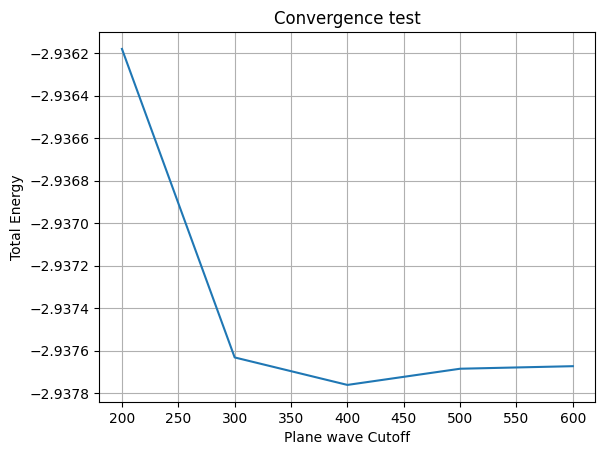

In [13]:
t = [200, 300, 400, 500, 600]
s = [-2.93618063, -2.93763127, -2.93776050, -2.93768436, -2.93767240]

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Plane wave Cutoff', ylabel='Total Energy',
       title='Convergence test')
ax.grid()

plt.show()

If you compare initial and final cell vector lenghts, you will notice that they did not indeed change.
The initial structure was already optimized, as you can see in the OUTCOR file in the TOTAL-FORCE section.

```
POSITION                                       TOTAL-FORCE (eV/Angst)
 -----------------------------------------------------------------------------------
      0.00000      0.00000      0.00000         0.000000      0.000000      0.000000

```



### 3. Calculating phonon spectrum

With forces in the Si cell being essentially zero, we can evaluate phonon modes.
In this tutorial we use a **finite displacements approach** implemented in the package Phonopy.
You can remind yourself about the concept of lattice dynamics and phonons with this document: https://www.neutron-sciences.org/articles/sfn/pdf/2011/01/sfn201112007.pdf and read about the finite displacement approach here: https://www.neutron-sciences.org/articles/sfn/pdf/2011/01/sfn201112008.pdf.

Finally, you can have  look at how it is implemented in Phonopy here: https://phonopy.github.io/phonopy/formulation.html.

The finite displacements approach constists of slightly displacing each atom of the unit cell from their equilibrium position, and perform a single-point DFT calculation for each displacement in order to compute the resulting forces, called Hellmann-Feynman forces (HFF). Using the HFF, the force constants of the structures are computed and provide the phonon modes (the eigenfrequencies and the eigenvectors). 
- Phonopy can propose a minimum number of displacements based on the symetry operation of the unitcell. Use the following cell to generate the displacement.

Here, we need to use a suprecell (2x2x2 cell). This is required since to capture phonon modes at smaller wave vectors (lower frequencies), you need a larger periodicity than the unit cell offers. The supercell essentially "scales up" the periodicity in real space, enabling the capture of phonon modes at lower wave vectors in reciprocal space. Additionally, a supercell allows you to capture longer-range interatomic force constants, which are crucial for accurate phonon calculations, especially for long-wavelength phonons that involve interactions across multiple unit cells.
Reducing artificial PBC effects inherent to a single unit cell model is another reason to use a larger supercell for a better approximation to true bulk properties.

In [ ]:
from ase.build.supercells import make_supercell
atoms=read(relaxation_dir+"/CONTCAR") #read relaxed cell

M = [[2, 0, 0], [0, 2, 0], [0, 0, 2]]
sc=make_supercell(atoms, M)

view(sc, viewer='x3d')

In [34]:
# Create the atomic displacement using Phonopy and write them out as POSCAR files #
unitcell, optional_structure_info = read_crystal_structure(relaxation_dir+"/CONTCAR", interface_mode='vasp') #read the relaxed cell
phonon = Phonopy(unitcell, supercell_matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]) #build a 2x2x2 supercell to perform the DFT calculations
phonon.generate_displacements(distance=0.03) #generate displacements of 0.03 A around the equilibrium positions
supercells = phonon.supercells_with_displacements 

In [ ]:
supercells[0].positions

Create a new directory for the phonon calculation, and ask ASE to write the displacements files.


In [28]:
#Function writing the displacement as a series of POSCAR files to be read by VASP.

def write_supercells_with_displacements(
    supercell, cells_with_displacements, directory, pre_filename="POSCAR", width=3
):
    ids = np.arange(len(cells_with_displacements), dtype=int) + 1
    write_vasp(directory+"S%s" % pre_filename, supercell, direct=True)
    for i, cell in zip(ids, cells_with_displacements):
        filename = directory+"{pre_filename}-{0:0{width}}".format(
            i, pre_filename=pre_filename, width=width
        )
        write_vasp(filename, cell, direct=True)

phonon_dir='si_phonons/'
write_supercells_with_displacements(supercell=phonon.supercell, cells_with_displacements=supercells,directory=phonon_dir)


Create VASP files for the single-point displacement calculations.

In [39]:
#Setup VASP for an energy and forces calculation#

# Function writing a VASP job script dedicated to the calculation of Hellman-Feynman Forces (HFF). 
# It launches a VASP run at the Gamma-point only for an array of displacements generated using Phonopy 

def write_job_HFF(directory,#The directory to write the file  
                  label,    #The job name
                  Nimg,     #The number of displacement 
                  nodes,    #The number of requested nodes
                  queue):   #The name of the requested queue in the cluster
    f = open(directory+'/ILL_hpc_vasp_job_local.sh', "w")
    f.write("""#!/bin/bash

#PBS -q """+queue+"""
#PBS -N """+label+"""
#PBS -l nodes="""+nodes+""":ppn="""+queue[-2:]+"""
# if nodes > 1 : FOR THE q.2015_16 queue activate one of the following lines:
#export I_MPI_DEVICE="rdma:ofa-v2-ib0" 
#export I_MPI_DEVICE="rdssm:ofa-v2-ib0"

module load intel/14.0.1
module load intelmpi/4.1.0.024
module load vasp/intelmpi/5.4.1

cd $PBS_O_WORKDIR
ulimit -s unlimited

for i in {001.."""+f'{Nimg:03d}'+"""}
do
cp POSCAR-$i POSCAR

mpirun vasp_std > vasp_job.log

wait

cp vasprun.xml vasprun-$i.xml
rm POSCAR OUTCAR

done

#End of script (make sure line before this gets run)""")
    
    f.close()

calc=Vasp(
    directory=phonon_dir,      
    label='Si_phonon',
    # Convergence parameters
    prec='Accurate',# Vasp precision tag
    encut=500,      # energy cutoff for the plane-wave basis set in eV
    ediff=1e-7,     # Relax electronic structure until 5e-7 eV energy change between 2 electronic loop
    # Job settings
    xc="pbe",       # Use the PBE exchange and correlation functional
    ibrion=-1,      # No ionic relaxation
    # K-point grid settings
    kpts=[8,8,8],   # Kpoint grid
    gamma=True,     # Gamma-centered grid
    # Output settings
    lwave=False,    # Do not save wave fuction files (large files)
)
#Write the VASP job script#
write_job_HFF(Nimg=len(phonon.displacements),directory=phonon_dir,label='BaTiO3-xHx_phonon_small_cell',nodes='1',queue='q.2015_16')
calc.write_input(atoms)

Once the calculation is finished (~1min), copy back your phonon calculation directory to your home folder. Then, let's use again Phonopy to parse the results using `parse_set_of_forces()` and compute the force constants using `phonon.produce_force_constants()`.

In [41]:
vasp_results=parse_set_of_forces(num_atoms=phonon.dataset['natom'], forces_filenames=[phonon_dir+'/vasprun-'+'{:03.0f}'.format(i)+'.xml' for i in np.arange(1,len(phonon.displacements)+1)], use_expat=True, verbose=True)
phonon.forces=vasp_results['forces']
phonon.produce_force_constants()

counter (file index): 1 

RuntimeError: Could not parse "<_io.BufferedReader name='si_phonons//vasprun-001.xml'>". Probably this vasprun.xml is broken or some value diverges. Check this calculation carefully before sending questions to the phonopy mailing list.

- Calculate the vDOS using Phonopy. Here, we use `run_projected_dos()` to separate the contribution from each species.

In [ ]:
phonon.run_mesh([15, 15, 15], with_eigenvectors=True, is_mesh_symmetry=False)
phonon.run_projected_dos(#sigma=0.05,
                         freq_min=None,
                         freq_max=None,
                         freq_pitch=0.05,
                         use_tetrahedron_method=True,
                         direction=None,
                         xyz_projection=False,
    )
vdos=phonon.get_projected_dos_dict()

- Plot the results

In [ ]:
%matplotlib inline
Si_indices=np.where(np.array(phonon.unitcell.symbols)=='Si')[0]

figvdos, ax=plt.subplots(1,1,figsize=(8,4),dpi=150)
ax.plot(vdos['frequency_points']*4.136, np.sum(vdos['projected_dos'][Si_indices,:],axis=0),label='Si')

ax.set_ylabel('vDOS')
ax.set_xlabel('energy (meV)')
ax.legend()